In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf 
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

----------- -----Visual of Orignal Data ------------

In [94]:
ticker = yf.Ticker('NVDA')
dfNVDA = ticker.history(period='5y')

In [95]:
dates = dfNVDA.index.to_numpy()
high_prices = dfNVDA['High'].to_numpy() 

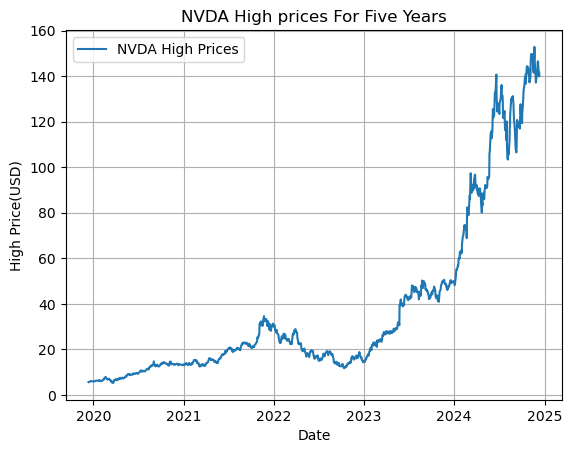

In [96]:
plt.plot(dates, high_prices, label='NVDA High Prices')
plt.title('NVDA High prices For Five Years')
plt.xlabel('Date')
plt.ylabel('High Price(USD)')
plt.grid(True)
plt.legend()
plt.show()

-----------ADF Test to test if Data is Stationary -----------

In [97]:
result = adfuller(dfNVDA['High'])  
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

In [98]:
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('\nCritical Values:')
for key, value in critical_values.items():
    print(f' {key}:{value}')

ADF Statistic: 1.6348034835382346
p-value: 0.997958322683976

Critical Values:
 1%:-3.4356090875394525
 5%:-2.863862410805964
 10%:-2.568006480268158


In [99]:
if result[1] < 0.05:
    print("Data is Stationary")
else:
    print("Not Stationary")  
# p-Value is greater than 0.05, we have to difference it

Not Stationary


----- Visual inspection if data is Non-stationary using Rolling Mean & Standard Deviation --------

In [100]:
rolling_mean = dfNVDA['High'].rolling(window=30).mean() 
rolling_std = dfNVDA['High'].rolling(window=30).std()    

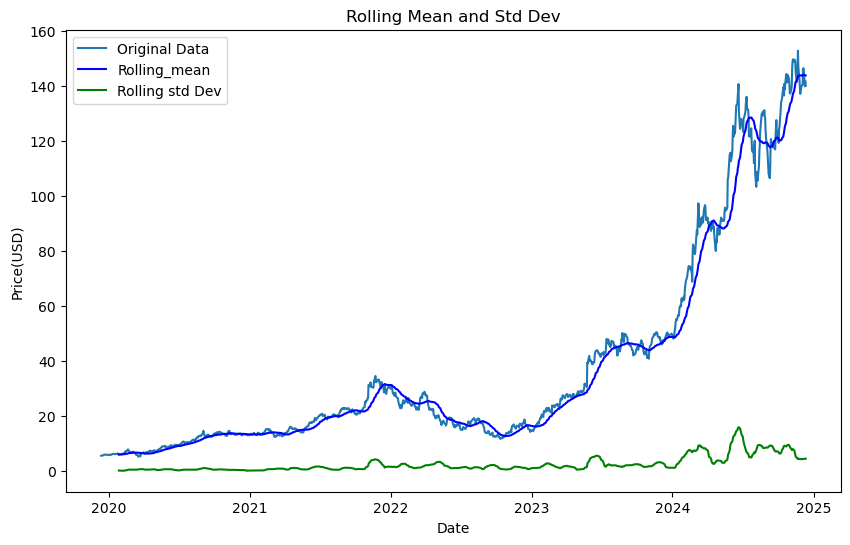

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(dfNVDA['High'], label='Original Data')  
plt.plot(rolling_mean, label='Rolling_mean', color='blue')
plt.plot(rolling_std, label='Rolling std Dev', color='green')
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend()
plt.title("Rolling Mean and Std Dev")
plt.show()

-----Example of Differencing Data if Not Stationary -----------

In [102]:
dfNVDA['diff'] = dfNVDA['High'].diff()  

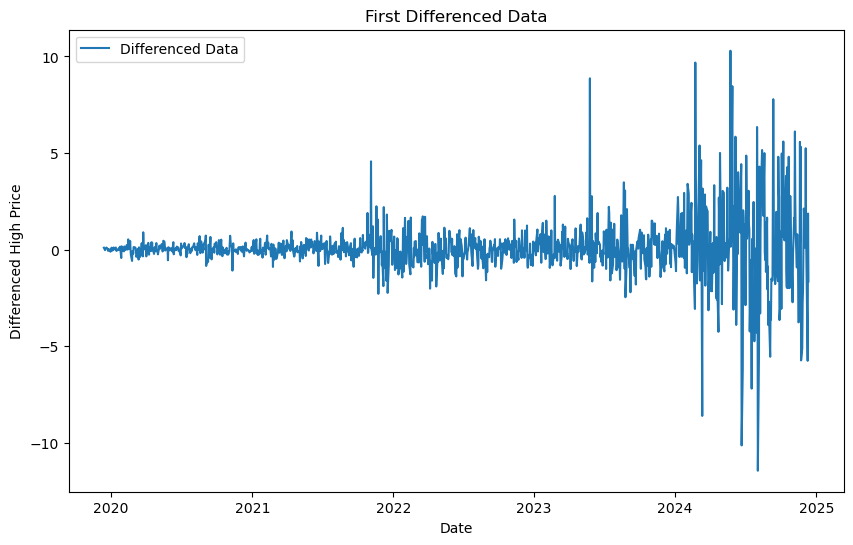

In [103]:
plt.figure(figsize=(10, 6))
plt.plot(dfNVDA['diff'], label='Differenced Data')
plt.title('First Differenced Data')
plt.xlabel('Date')
plt.ylabel('Differenced High Price')
plt.legend()
plt.show()

-------------- ADF Test After Differencing ---------

In [104]:
adf_result_diff = adfuller(dfNVDA['diff'].dropna())  

In [105]:
print(f'ADF Statistic: {adf_result_diff[0]}')
print(f'p-value: {adf_result_diff[1]}')
print("Critical Values:")
for key, value in adf_result_diff[4].items():
    print(f"{key}: {value}")

ADF Statistic: -10.812449326662907
p-value: 1.8935721160819575e-19
Critical Values:
1%: -3.4356090875394525
5%: -2.863862410805964
10%: -2.568006480268158


In [106]:
if adf_result_diff[1] < 0.05:
    print("Data is Stationary")
else:
    print("Data is not Stationary")

Data is Stationary


----------- Prepare Data By Splitting into Train and Test --------

In [107]:
train_size = int(len(high_prices) * 0.9) 
train = high_prices[:train_size]  
test = high_prices[train_size:]   

In [108]:
train_dates = dates[:train_size]
test_dates = dates[train_size:]

Plot Training and Testing Data

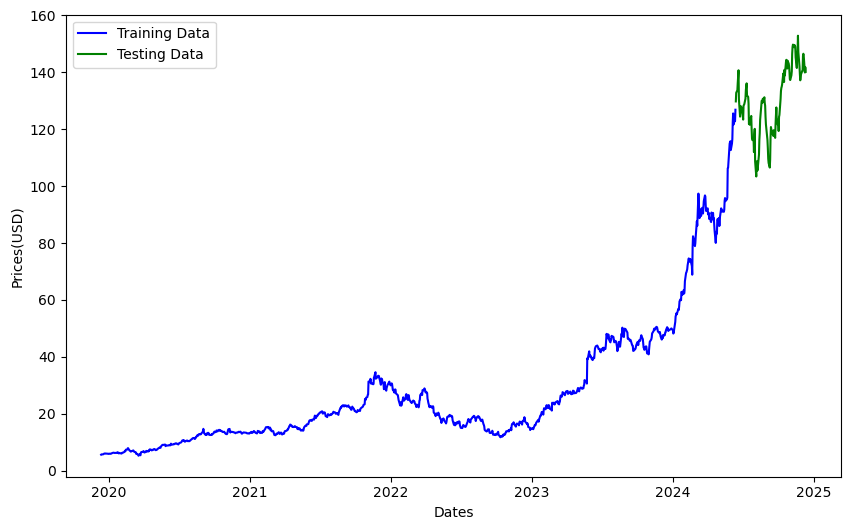

In [109]:
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train, label='Training Data', color='blue')
plt.plot(test_dates, test, label='Testing Data', color='green')
plt.xlabel('Dates')
plt.ylabel('Prices(USD)')
plt.legend()
plt.show()

Log Transformation for Training and Testing Data

In [110]:
log_train = np.log(train)
log_test = np.log(test)

---------- Auto-ARIMA Model for Training Data ---------

In [111]:
auto_model = auto_arima(log_train, seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4803.942, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4808.516, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4809.885, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4809.829, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4800.199, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4807.938, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4807.926, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4805.917, Time=0.67 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4802.696, Time=0.20 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 3.145 seconds


---------- Forecasting with the ARIMA Model ----------

In [112]:
forecast_steps = len(log_test)
forecast_log, conf_int= auto_model.predict(n_periods=forecast_steps, return_conf_int=True)

Reverse the Log Transformation

In [113]:
forecast = np.exp(forecast_log)

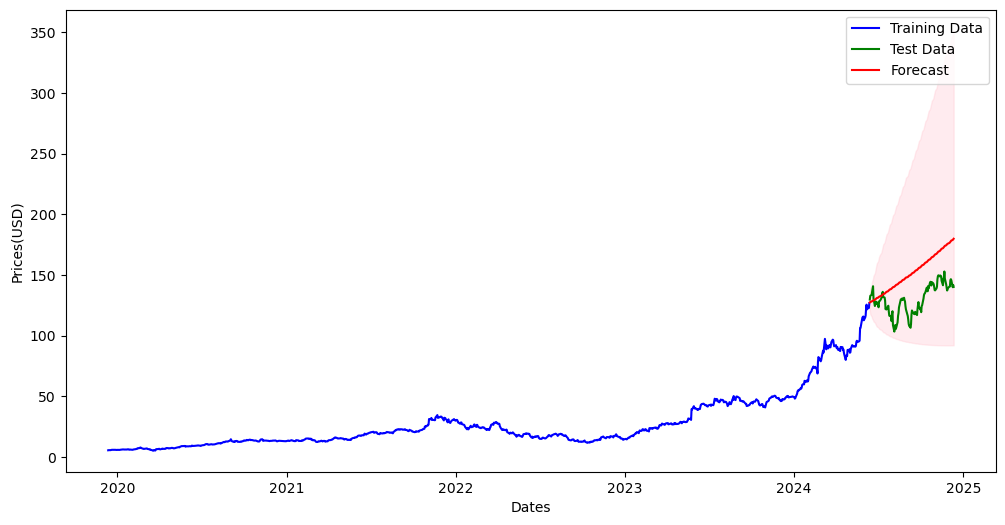

In [114]:
plt.figure(figsize=(12, 6))
plt.plot(train_dates, train, label='Training Data', color='blue')
plt.plot(test_dates, test, label='Test Data', color='green')
plt.plot(test_dates, forecast, label='Forecast', color='red')
plt.fill_between(test_dates, np.exp(conf_int[:, 0]), np.exp(conf_int[:, 1]), color='pink', alpha=0.3 )
plt.xlabel('Dates')
plt.ylabel('Prices(USD)')
plt.legend()
plt.show()

------- Calculate the Performance of the Model----------

In [115]:
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test))  # less than 10% = exellent, 10-20% = good, greater than 20% = not good
print(f'(MAE) on Test Data: {mae:2f}')
print(f'(MSE) on Test Data: {mse:2f}')
print(f'(RMSE) on Test Data: {rmse:2f}')
print(f'(MAPE) on Test Data: {mape:2f}')

(MAE) on Test Data: 23.015308
(MSE) on Test Data: 654.503313
(RMSE) on Test Data: 25.583262
(MAPE) on Test Data: 0.181035


--------- Forecasting Future Data (n Days) -------

In [116]:
log_high_prices = np.log(high_prices)  
# Auto-ARIMA Model
auto_model = auto_arima(log_high_prices, seasonal=True, trace=True, stepwise=True)
forecast_steps_n = 100
forecast_log_n, conf_int_n = auto_model.predict(n_periods=forecast_steps_n, return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5360.325, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5362.420, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5366.324, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5366.307, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5354.387, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5364.325, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5364.325, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5362.440, Time=0.85 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5359.639, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 3.586 seconds


Reverse the Log Transformation 

In [117]:
forecast_n = np.exp(forecast_log_n)
last_date = dates[-1]
forecast_dates_n = pd.date_range(start=last_date, periods=forecast_steps_n + 1, freq='B')[1:]
forecast_dates_n = np.array(forecast_dates_n)

Plot 

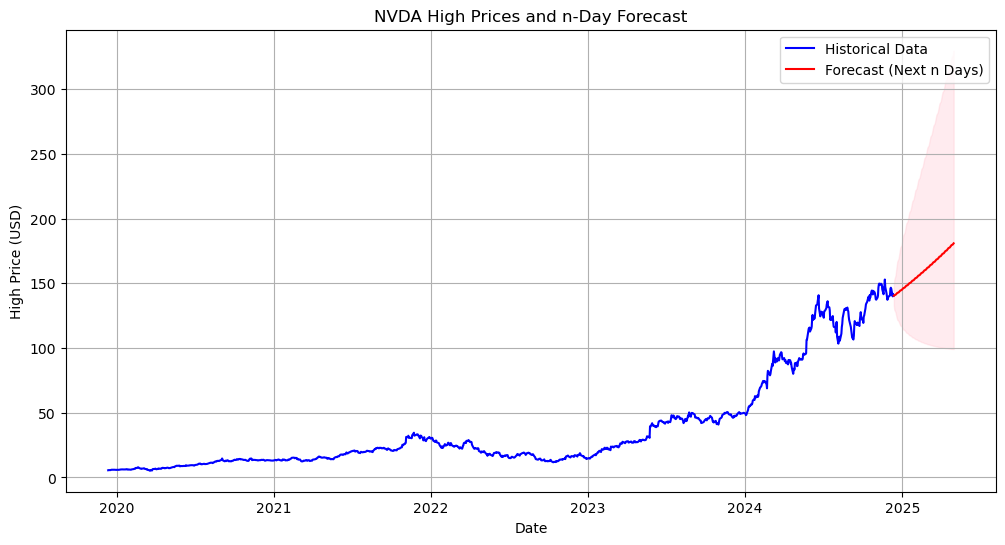

In [118]:
plt.figure(figsize=(12, 6))
plt.plot(dates, high_prices, label='Historical Data', color='blue')  
plt.plot(forecast_dates_n, forecast_n, label='Forecast (Next n Days)', color='red')
plt.fill_between(forecast_dates_n, np.exp(conf_int_n[:, 0]), np.exp(conf_int_n[:, 1]), color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('High Price (USD)')
plt.title('NVDA High Prices and n-Day Forecast')
plt.legend()
plt.grid(True)
plt.show()

---------------Forecasted Data Printed for n -----

In [119]:
forecast_df_n = pd.DataFrame({'Date': forecast_dates_n, 'Predicted Price': forecast_n})
print(forecast_df_n)

                        Date  Predicted Price
0  2024-12-12 00:00:00-05:00       140.391707
1  2024-12-13 00:00:00-05:00       140.741729
2  2024-12-16 00:00:00-05:00       141.101412
3  2024-12-17 00:00:00-05:00       141.462617
4  2024-12-18 00:00:00-05:00       141.824789
..                       ...              ...
95 2025-04-24 00:00:00-04:00       178.980047
96 2025-04-25 00:00:00-04:00       179.438274
97 2025-04-28 00:00:00-04:00       179.897675
98 2025-04-29 00:00:00-04:00       180.358252
99 2025-04-30 00:00:00-04:00       180.820008

[100 rows x 2 columns]
